# Modeling Hexagonal Lattices
In this example, we will create a hexagonal lattice and show how the orientation can be changed via the cell rotation property. Let's first just set up some materials and universes that we will use to fill the lattice.

In [1]:
%matplotlib inline
import openmc

In [2]:
fuel = openmc.Material(name='fuel')
fuel.add_nuclide('U235', 1.0)
fuel.set_density('g/cm3', 10.0)

fuel2 = openmc.Material(name='fuel2')
fuel2.add_nuclide('U238', 1.0)
fuel2.set_density('g/cm3', 10.0)

water = openmc.Material(name='water')
water.add_nuclide('H1', 2.0)
water.add_nuclide('O16', 1.0)
water.set_density('g/cm3', 1.0)

materials = openmc.Materials((fuel, fuel2, water))
materials.export_to_xml()

With our three materials, we will set up two universes that represent pin-cells: one with a small pin and one with a big pin. Since we will be using these universes in a lattice, it's always a good idea to have an "outer" universe as well that is applied outside the defined lattice.

In [3]:
r_pin = openmc.ZCylinder(r=0.25)
fuel_cell = openmc.Cell(fill=fuel, region=-r_pin)
water_cell = openmc.Cell(fill=water, region=+r_pin)
pin_universe = openmc.Universe(cells=(fuel_cell, water_cell))

r_big_pin = openmc.ZCylinder(r=0.5)
fuel2_cell = openmc.Cell(fill=fuel2, region=-r_big_pin)
water2_cell = openmc.Cell(fill=water, region=+r_big_pin)
big_pin_universe = openmc.Universe(cells=(fuel2_cell, water2_cell))

all_water_cell = openmc.Cell(fill=water)
outer_universe = openmc.Universe(cells=(all_water_cell,))

Now let's create a hexagonal lattice using the `HexLattice` class:

In [4]:
lattice = openmc.HexLattice()

We need to set the `center` of the lattice, the `pitch`, an `outer` universe (which is applied to all lattice elements outside of those that are defined), and a list of `universes`. Let's start with the easy ones first. Note that for a 2D lattice, we only need to specify a single number for the pitch.

In [5]:
lattice.center = (0., 0.)
lattice.pitch = (1.25,)
lattice.outer = outer_universe

Now we need to set the `universes` property on our lattice. It needs to be set to a list of lists of Universes, where each list of Universes corresponds to a ring of the lattice. The rings are ordered from outermost to innermost, and within each ring the indexing starts at the "top". To help visualize the proper indices, we can use the `show_indices()` helper method.

In [6]:
print(lattice.show_indices(num_rings=4))

                  (0, 0)
            (0,17)      (0, 1)
      (0,16)      (1, 0)      (0, 2)
(0,15)      (1,11)      (1, 1)      (0, 3)
      (1,10)      (2, 0)      (1, 2)
(0,14)      (2, 5)      (2, 1)      (0, 4)
      (1, 9)      (3, 0)      (1, 3)
(0,13)      (2, 4)      (2, 2)      (0, 5)
      (1, 8)      (2, 3)      (1, 4)
(0,12)      (1, 7)      (1, 5)      (0, 6)
      (0,11)      (1, 6)      (0, 7)
            (0,10)      (0, 8)
                  (0, 9)


Let's set up a lattice where the first element in each ring is the big pin universe and all other elements are regular pin universes. 

From the diagram above, we see that the outer ring has 18 elements, the first ring has 12, and the second ring has 6 elements. The innermost ring of any hexagonal lattice will have only a single element. 

We build these rings through 'list concatenation' as follows: 

In [7]:
outer_ring = [big_pin_universe] + [pin_universe]*17 # Adds up to 18

ring_1 = [big_pin_universe] + [pin_universe]*11 # Adds up to 12

ring_2 = [big_pin_universe] + [pin_universe]*5 # Adds up to 6

inner_ring = [big_pin_universe]

We can now assign the rings (and the universes they contain) to our lattice. 

In [8]:
lattice.universes = [outer_ring, 
                     ring_1, 
                     ring_2,
                     inner_ring]
print(lattice)

HexLattice
	ID             =	4
	Name           =	
	Orientation    =	y
	# Rings        =	4
	# Axial        =	None
	Center         =	(0.0, 0.0)
	Pitch          =	(1.25,)
	Outer          =	3
	Universes      
   2
  1 1
 1 2 1
1 1 1 1
 1 2 1
1 1 1 1
 1 2 1
1 1 1 1
 1 1 1
1 1 1 1
 1 1 1
  1 1
   1


Now let's put our lattice inside a circular cell that will serve as the top-level cell for our geometry.

In [9]:
outer_surface = openmc.ZCylinder(r=5.0, boundary_type='vacuum')
main_cell = openmc.Cell(fill=lattice, region=-outer_surface)
geometry = openmc.Geometry([main_cell])
geometry.export_to_xml()

Now let's create a plot to see what our geometry looks like.

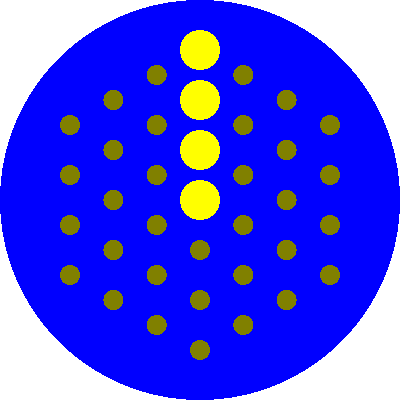

In [10]:
plot = openmc.Plot.from_geometry(geometry)
plot.color_by = 'material'
plot.colors = colors = {
    water: 'blue',
    fuel: 'olive',
    fuel2: 'yellow'
}
plot.to_ipython_image()

At this point, if we wanted to simulate the model, we would need to create an instance of `openmc.Settings`, export it to XML, and run.

## Lattice orientation

Now let's say we want our hexagonal lattice orientated such that two sides of the lattice are parallel to the x-axis. This can be achieved by two means: either we can rotate the cell that contains the lattice, or we can can change the `HexLattice.orientation` attribute. By default, the `orientation` is set to "y", indicating that two sides of the lattice are parallel to the y-axis, but we can also change it to "x" to make them parallel to the x-axis.

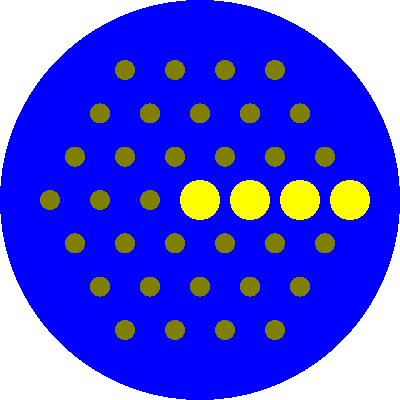

In [11]:
# Change the orientation of the lattice and re-export the geometry
lattice.orientation = 'x'
geometry.export_to_xml()

# Run OpenMC in plotting mode
plot.to_ipython_image()

When we change the orientation to 'x', you can see that the first universe in each ring starts to the right along the x-axis. As before, the universes are defined in a clockwise fashion around each ring. To see the proper indices for a hexagonal lattice in this orientation, we can again call `show_indices` but pass an extra orientation argument:

In [12]:
print(lattice.show_indices(4, orientation='x'))

                  (0,12)      (0,13)      (0,14)      (0,15)

            (0,11)      (1, 8)      (1, 9)      (1,10)      (0,16)

      (0,10)      (1, 7)      (2, 4)      (2, 5)      (1,11)      (0,17)

(0, 9)      (1, 6)      (2, 3)      (3, 0)      (2, 0)      (1, 0)      (0, 0)

      (0, 8)      (1, 5)      (2, 2)      (2, 1)      (1, 1)      (0, 1)

            (0, 7)      (1, 4)      (1, 3)      (1, 2)      (0, 2)

                  (0, 6)      (0, 5)      (0, 4)      (0, 3)


## Hexagonal prisms

OpenMC also contains a convenience function that can create a hexagonal prism representing the interior region of six surfaces defining a hexagon. This can be useful as a bounding surface of a hexagonal lattice. For example, if we wanted the outer boundary of our geometry to be hexagonal, we could change the `region` of the main cell:

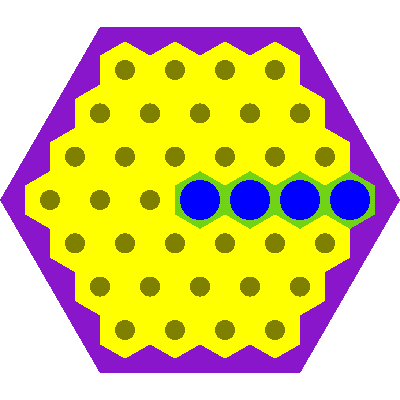

In [13]:
main_cell.region = openmc.model.hexagonal_prism(
    edge_length=4*lattice.pitch[0],
    orientation='x',
    boundary_type='vacuum'
)
geometry.export_to_xml()

# Run OpenMC in plotting mode
plot.color_by = 'cell'
plot.to_ipython_image()